In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# 1. Boostrap basics

In [3]:
np.random.seed(30)
normal_data = np.random.normal(4, 1.5, 50)

To the best of the GSIs' knowledge, there is no perfect package for boostrap validation in `Python`. Therefore, the function below is a simple manual implementation of the bootstrap. Note that there is nothing tricky in the code below and you are encouraged to try the implementation on your own. It is actually a required exercise for statistics majors.

For `R` users, a package that is widely used for bootstrapping in `R` is `boot`. 

In [4]:
def bootstrap(data, metrics,sample =500, random_state=123):
    output_array=np.zeros(sample)
    output_array[:]=np.nan
    for i in range(sample):
        bs_data = np.random.choice(data, len(data), replace=True)
        output_array[i] = metrics(bs_data)
    return output_array

In [5]:
boot_out = bootstrap(normal_data, np.mean)

(array([ 1.,  0.,  1.,  0.,  5.,  4.,  9., 15., 19., 28., 42., 38., 28.,
        38., 45., 45., 40., 38., 32., 31., 11., 10.,  7.,  6.,  3.,  3.,
         0.,  0.,  0.,  1.]),
 array([3.11084657, 3.16340807, 3.21596957, 3.26853107, 3.32109257,
        3.37365407, 3.42621557, 3.47877707, 3.53133857, 3.58390006,
        3.63646156, 3.68902306, 3.74158456, 3.79414606, 3.84670756,
        3.89926906, 3.95183056, 4.00439206, 4.05695356, 4.10951506,
        4.16207656, 4.21463806, 4.26719956, 4.31976106, 4.37232256,
        4.42488406, 4.47744556, 4.53000706, 4.58256856, 4.63513006,
        4.68769156]),
 <a list of 30 Patch objects>)

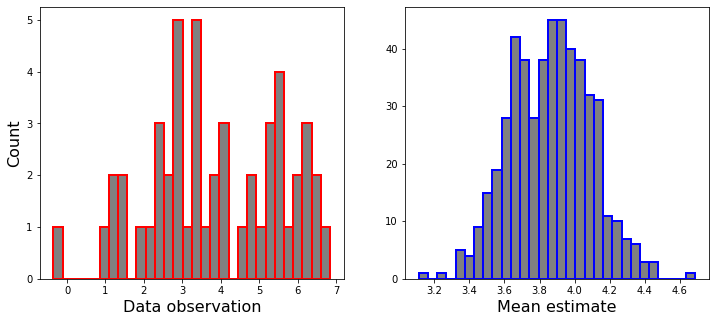

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Data observation', fontsize=16)
axs[1].set_xlabel('Mean estimate', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(normal_data,bins=30,edgecolor='red', linewidth=2,color = "grey")
axs[1].hist(boot_out,bins=30,edgecolor='blue', linewidth=2,color = "grey")

Using the bootstrap output, you can compute the stiatistics (e.g., mean, standard deviation, quantiles) of the boostrap estimates.

In [13]:
print("mean of the estimate %.2f" % np.mean(boot_out))
print("sd of the estimate: %.2f " % np.std(boot_out))
print("0.025-quantile of the estimate: %.2f " % np.quantile(boot_out, 0.025))
print("0.975-quantile of the estimate: %.2f " % np.quantile(boot_out, 0.975))

mean of the estimate 3.87
sd of the estimate: 0.23 
0.025-quantile of the estimate: 3.44 
0.975-quantile of the estimate: 4.32 


## 2. Bootstrap for Model Validation 

### 2.1 Preliminaries

#### 2.1.1 From Lab 7

In [14]:
ctr = pd.read_csv("CTR.csv")

from sklearn.model_selection import train_test_split

y = ctr['CTR']
X = pd.get_dummies(ctr.drop(['CTR'], axis=1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)
X_train.shape, X_test.shape

((4239, 18), (1818, 18))

In [15]:
def OSR2(model, X_test, y_test, y_train):
    
    y_pred = model.predict(X_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(y_train))**2)
                 
    return (1 - SSE/SST)

Note that we take the random forest model as an example; However, bootstrap for valiation can be applied to any trained model.

Below, we train the random forest model, on the training data and with the best parameters found through cross-validation in Lab 7.

In [16]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=11, min_samples_leaf=5, 
                           n_estimators = 500, random_state=88, verbose=1)
# Note: you can change the verbose parameter to control how much training progress is printed.
rf.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    3.5s finished


RandomForestRegressor(max_features=11, min_samples_leaf=5, n_estimators=500,
                      random_state=88, verbose=1)

In [17]:
rf.verbose = False
print('OSR2:', round(OSR2(rf, X_test, y_test, y_train), 5))

OSR2: 0.56398


#### 2.1.2 Define metrics functions

In [18]:
def OS_R_squared(predictions, y_test,y_train):
    SSE = np.sum((y_test-predictions)**2)
    SST = np.sum((y_test-np.mean(y_train))**2)
    r2 = 1-SSE/SST
    return r2

def mean_squared_error(predictions, y_test,y_train):
    MSE = np.mean((y_test-predictions)**2)
    return MSE

def mean_absolute_error(predictions, y_test,y_train):
    MAE = np.mean(np.abs(y_test-predictions))
    return MAE

#### 2.1.3 Sanity check

In [19]:
y_pred = rf.predict(X_test)
print("OSR2: %s" % OS_R_squared(y_pred,y_test,y_train))
print("MSE: %s" % mean_squared_error(y_pred,y_test,y_train))
print("MAE: %s" % mean_absolute_error(y_pred,y_test,y_train))

OSR2: 0.5639762833152002
MSE: 0.0023534658642130326
MAE: 0.0291244008514368


In [20]:
print("OSR2: %s" % OSR2(rf, X_test, y_test,y_train))
print("MSE: %s" % np.mean((y_pred-y_test)**2))
print("MAE: %s" % np.mean(np.abs(y_pred-y_test)))

OSR2: 0.5639762833152002
MSE: 0.0023534658642130326
MAE: 0.0291244008514368


### 2.2 Boostrapping

#### 2.2.1 Manually code the bootstrap method

Again, below is a manual implementation of bootstrap for model valiation.

In [21]:
import time

def bootstrap_validation(test_data, test_label, train_label, model, metrics_list, sample=500, random_state=66):
    tic = time.time()
    n_sample = sample
    n_metrics = len(metrics_list)
    output_array=np.zeros([n_sample, n_metrics])
    output_array[:]=np.nan
    print(output_array.shape)
    for bs_iter in range(n_sample):
        bs_index = np.random.choice(test_data.index, len(test_data.index), replace=True)
        bs_data = test_data.loc[bs_index]
        bs_label = test_label.loc[bs_index]
        bs_predicted = model.predict(bs_data)
        for metrics_iter in range(n_metrics):
            metrics = metrics_list[metrics_iter]
            output_array[bs_iter, metrics_iter]=metrics(bs_predicted,bs_label,train_label)
#         if bs_iter % 100 == 0:
#             print(bs_iter, time.time()-tic)
    output_df = pd.DataFrame(output_array)
    return output_df

#### 2.2.2 Do bootstrap

Note that here we use B = 5,000, instead of 10,000 as shown in the lecutre. Later, you will observe in the histogram that with this resampling size, the estimates of the metrics have already displayed the nice normal curve shape.

The following code takes about 10 minutes to run. You might want to reduce the value of B for a trial run. However, B should not be too small; otherwise, the estimates may not converge to the standard normal distribution well.

In [22]:
bs_output = bootstrap_validation(X_test,y_test,y_train,rf,
                                 metrics_list=[OS_R_squared, mean_squared_error,mean_absolute_error],
                                 sample = 5000)

(5000, 3)


### 2.3 Visualization

#### 2.3.1 Basic plot and centered plot

(-0.15, 0.15)

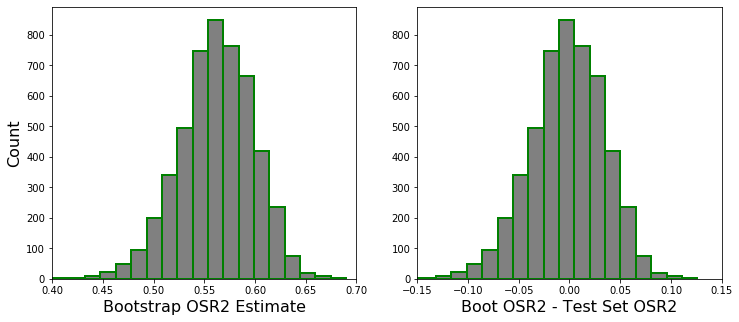

In [23]:
test_OSR2 = OS_R_squared(y_pred,y_test,y_train)

fig, axs = plt.subplots(ncols=2, figsize=(12,5))
axs[0].set_xlabel('Bootstrap OSR2 Estimate', fontsize=16)
axs[1].set_xlabel('Boot OSR2 - Test Set OSR2', fontsize=16)
axs[0].set_ylabel('Count', fontsize=16)
axs[0].hist(bs_output.iloc[:,0], bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[0].set_xlim([0.4,0.7])
axs[1].hist(bs_output.iloc[:,0]-test_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs[1].set_xlim([-0.15,0.15])

#### 2.3.2 manual CI + plot

In [24]:
# The 95% confidence interval
CI= np.quantile(bs_output.iloc[:,0]-test_OSR2,np.array([0.025,0.975]))
print("The 95-percent confidence interval of OSR2 is %s" % CI)

The 95-percent confidence interval of OSR2 is [-0.07805046  0.06296383]


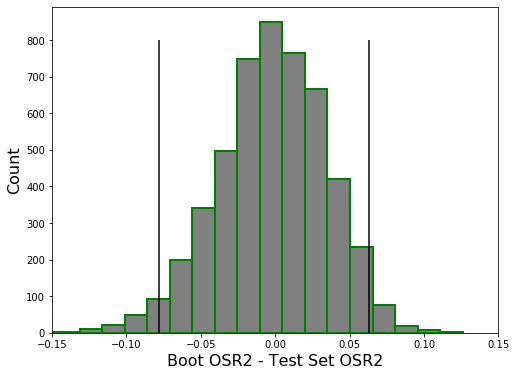

In [25]:
fig, axs = plt.subplots(ncols=1, figsize=(8,6))
axs.set_xlabel('Boot OSR2 - Test Set OSR2', fontsize=16)
axs.set_ylabel('Count', fontsize=16)
axs.hist(bs_output.iloc[:,0]-test_OSR2, bins=20,edgecolor='green', linewidth=2,color = "grey")
axs.set_xlim([-0.15,0.15])
axs.vlines(x=CI[0], ymin = 0, ymax =800, color = "black")
axs.vlines(x=CI[1], ymin = 0, ymax =800, color = "black")

### 2.4 Exercise

Try to re-do this exercise with another models that we did in Lab 7, e.g., linear regression, decision tree, and bagging